In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
validation_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_validation.csv')
validation_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Validation/'

test_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_test.csv')
test_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Test/'

In [0]:
# Create seperate dfs for classification and localization
    
validation_list = []
for i in os.listdir(validation_path):
  if i.startswith('pos'): validation_list.append(i)
    
val_loc_df = pd.DataFrame({'x_col': validation_list})
val_class_df = pd.DataFrame({'x_col': os.listdir(validation_path)})

test_list = []
for i in os.listdir(test_path):
  if i.startswith('pos'): test_list.append(i)
    
test_loc_df = pd.DataFrame({'x_col': test_list})
test_class_df = pd.DataFrame({'x_col': os.listdir(test_path)})

In [0]:
# Now we need to structure the dataframes for the flow_from_dataframe keras method

for i,img in enumerate(val_loc_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      val_loc_df.loc[i, 'voxel_x'] = validation_labels.loc[img_id, 'voxel_x']
      val_loc_df.loc[i, 'voxel_y'] = validation_labels.loc[img_id, 'voxel_y']
      val_loc_df.loc[i, 'diameter'] = validation_labels.loc[img_id, 'voxel_d2']

      
for i,img in enumerate(val_class_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      val_class_df.loc[i, 'nodule'] = 'yes'

    else:
      val_class_df.loc[i, 'nodule'] ='no'
      
for i,img in enumerate(test_loc_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      test_loc_df.loc[i, 'voxel_x'] = test_labels.loc[img_id, 'voxel_x']
      test_loc_df.loc[i, 'voxel_y'] = test_labels.loc[img_id, 'voxel_y']
      test_loc_df.loc[i, 'diameter'] = test_labels.loc[img_id, 'voxel_d2']

      
for i,img in enumerate(test_class_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      test_class_df.loc[i, 'nodule'] = 'yes'

    else:
      test_class_df.loc[i, 'nodule'] ='no'

In [7]:
val_loc_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=val_loc_df,
                                                                     x_col='x_col',
                                                                     y_col=['voxel_x','voxel_y','diameter'],
                                                                     directory=validation_path,
                                                                     target_size=(65,65),
                                                                     class_mode='raw',
                                                                     shuffle=False,
                                                                     batch_size=225)

val_class_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=val_class_df,
                                                                     x_col='x_col',
                                                                     y_col='nodule',
                                                                     directory=validation_path,
                                                                     target_size=(65,65),
                                                                     class_mode='binary',
                                                                     shuffle=False,
                                                                     batch_size=412)

test_loc_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_loc_df,
                                                                     x_col='x_col',
                                                                     y_col=['voxel_x','voxel_y','diameter'],
                                                                     directory=test_path,
                                                                     target_size=(65,65),
                                                                     class_mode='raw',
                                                                     shuffle=False,
                                                                     batch_size=102)

test_class_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_class_df,
                                                                     x_col='x_col',
                                                                     y_col='nodule',
                                                                     directory=test_path,
                                                                     target_size=(65,65),
                                                                     class_mode='binary',
                                                                     shuffle=False,
                                                                     batch_size=173)



Found 225 validated image filenames.
Found 412 validated image filenames belonging to 2 classes.
Found 102 validated image filenames.
Found 173 validated image filenames belonging to 2 classes.


In [0]:
loc_models = ['localization_model', 'localization_DA', 'localization_0.2_dropout2']
class_models = ['classification', 'classification_with_DA', 'classification_0.2_dropout']

loc_df = pd.DataFrame()
class_df = pd.DataFrame()

Now we will loop through our lists of models and compute performance statistics in the validation and test sets. Because some of our models are trained on augmented data, it would be innapropriate to compare performance statistics in the training sets. 

Also, there is currently a bug in Keras loading the VGG16 models, so we will have to load these seperately from the model lists.

In [0]:
# Compute localization stats

for i,m in enumerate(loc_models):
  model = load_model(f'/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/{m}.hdf5')
  val_preds = model.predict_generator(val_loc_batches, steps=1)
  test_preds = model.predict_generator(test_loc_batches, steps=1)
  
  loc_df.loc[i,'model'] = m
  
  # Validation scores
  loc_df.loc[i, 'val_x_err'] = mean_absolute_error(val_loc_df['voxel_x'], val_preds[:,0])
  loc_df.loc[i, 'val_y_err'] = mean_absolute_error(val_loc_df['voxel_y'], val_preds[:,1])
  loc_df.loc[i, 'val_diameter_err'] = mean_absolute_error(val_loc_df['diameter'], val_preds[:,2])
  
  # Test scores
  loc_df.loc[i,'test_x_err'] = mean_absolute_error(test_loc_df['voxel_x'], test_preds[:,0])
  loc_df.loc[i,'test_y_err'] = mean_absolute_error(test_loc_df['voxel_y'], test_preds[:,1])
  loc_df.loc[i,'test_diameter_err'] = mean_absolute_error(test_loc_df['diameter'], test_preds[:,2])

In [0]:
# Compute classification stats  
  
for i,m in enumerate(class_models):
    model = load_model(f'/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/{m}.hdf5')
    val_preds = np.where(model.predict_generator(val_class_batches, steps=1)<0.5,'no','yes')[:,0]
    test_preds = np.where(model.predict_generator(test_class_batches, steps=1)<0.5, 'no','yes')[:,0]
     
    class_df.loc[i,'model'] = m

    # Validation scores

    class_df.loc[i, 'val_accuracy'] = accuracy_score(val_class_df['nodule'],val_preds)
    class_df.loc[i, 'val_precision'] = precision_score(val_class_df['nodule'],val_preds, pos_label='yes')
    class_df.loc[i, 'val_recall'] = recall_score(val_class_df['nodule'],val_preds, pos_label='yes')
    class_df.loc[i, 'val_f1'] = f1_score(val_class_df['nodule'],val_preds, pos_label='yes')
    
    # Test scores

    class_df.loc[i, 'test_accuracy'] = accuracy_score(test_class_df['nodule'],test_preds)
    class_df.loc[i, 'test_precision'] = precision_score(test_class_df['nodule'],test_preds, pos_label='yes')
    class_df.loc[i, 'test_recall'] = recall_score(test_class_df['nodule'],test_preds, pos_label='yes')
    class_df.loc[i, 'test_f1'] = f1_score(test_class_df['nodule'],test_preds, pos_label='yes')

Now we will need to add the VGG16 models to our tables, we need to manually create the architecture for these and then add the saved weights. We will also need to use new generators as the smallest input shape that can be used by the VGG16 models is 150,150.

In [11]:
val_loc_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=val_loc_df,
                                                                     x_col='x_col',
                                                                     y_col=['voxel_x','voxel_y','diameter'],
                                                                     directory=validation_path,
                                                                     target_size=(150,150),
                                                                     class_mode='raw',
                                                                     shuffle=False,
                                                                     batch_size=225)

val_class_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=val_class_df,
                                                                     x_col='x_col',
                                                                     y_col='nodule',
                                                                     directory=validation_path,
                                                                     target_size=(150,150),
                                                                     class_mode='binary',
                                                                     shuffle=False,
                                                                     batch_size=412)

test_loc_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_loc_df,
                                                                     x_col='x_col',
                                                                     y_col=['voxel_x','voxel_y','diameter'],
                                                                     directory=test_path,
                                                                     target_size=(150,150),
                                                                     class_mode='raw',
                                                                     shuffle=False,
                                                                     batch_size=102)

test_class_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_class_df,
                                                                     x_col='x_col',
                                                                     y_col='nodule',
                                                                     directory=test_path,
                                                                     target_size=(150,150),
                                                                     class_mode='binary',
                                                                     shuffle=False,
                                                                     batch_size=173)

Found 225 validated image filenames.
Found 412 validated image filenames belonging to 2 classes.
Found 102 validated image filenames.
Found 173 validated image filenames belonging to 2 classes.


In [0]:
loc_models = ['VGG16_localization', 'VGG16_localization_DA']
class_models = ['VGG16_classification', 'VGG16_classification_with_DA']

In [13]:
# Create the architecture of our localization and classification models

VGG16 = keras.applications.vgg16.VGG16(include_top=False, input_shape=(150,150,3))

loc_model = Sequential()

for layer in VGG16.layers[:-1]:
  loc_model.add(layer)
  
for layer in model.layers:
  layer.trainable = False
  
  
loc_model.add(MaxPooling2D(2,2))
loc_model.add(Flatten())
loc_model.add(Dense(1024, activation='relu'))
loc_model.add(Dense(1024, activation='relu'))
loc_model.add(Dense(3, activation='linear'))

class_model = Sequential()

for layer in VGG16.layers[:-1]:
  class_model.add(layer)
  
for layer in model.layers:
  layer.trainable = False
  
  
class_model.add(MaxPooling2D(2,2))
class_model.add(Flatten())
class_model.add(Dense(1024, activation='relu'))
class_model.add(Dense(1024, activation='relu'))
class_model.add(Dense(1, activation='sigmoid'))

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
# Compute localization stats
i = loc_df.shape[0]+1
  
for m in loc_models:
  
  loc_model.load_weights(f'/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/{m}.hdf5')
  val_preds = loc_model.predict_generator(val_loc_batches, steps=1)
  test_preds = loc_model.predict_generator(test_loc_batches, steps=1)
  
  loc_df.loc[i,'model'] = m
  
  # Validation scores
  loc_df.loc[i, 'val_x_err'] = mean_absolute_error(val_loc_df['voxel_x'], val_preds[:,0])
  loc_df.loc[i, 'val_y_err'] = mean_absolute_error(val_loc_df['voxel_y'], val_preds[:,1])
  loc_df.loc[i, 'val_diameter_err'] = mean_absolute_error(val_loc_df['diameter'], val_preds[:,2])
  
  # Test scores
  loc_df.loc[i,'test_x_err'] = mean_absolute_error(test_loc_df['voxel_x'], test_preds[:,0])
  loc_df.loc[i,'test_y_err'] = mean_absolute_error(test_loc_df['voxel_y'], test_preds[:,1])
  loc_df.loc[i,'test_diameter_err'] = mean_absolute_error(test_loc_df['diameter'], test_preds[:,2])
  
  i = i+1

In [0]:
# Compute classification stats  
i = class_df.shape[0]+1

for m in class_models:
  
    class_model.load_weights(f'/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/{m}.hdf5')
    val_preds = np.where(class_model.predict_generator(val_class_batches, steps=1)<0.5,'no','yes')[:,0]
    test_preds = np.where(class_model.predict_generator(test_class_batches, steps=1)<0.5, 'no','yes')[:,0]
     
    class_df.loc[i,'model'] = m

    # Validation scores

    class_df.loc[i, 'val_accuracy'] = accuracy_score(val_class_df['nodule'],val_preds)
    class_df.loc[i, 'val_precision'] = precision_score(val_class_df['nodule'],val_preds, pos_label='yes')
    class_df.loc[i, 'val_recall'] = recall_score(val_class_df['nodule'],val_preds, pos_label='yes')
    class_df.loc[i, 'val_f1'] = f1_score(val_class_df['nodule'],val_preds, pos_label='yes')
    
    # Test scores

    class_df.loc[i, 'test_accuracy'] = accuracy_score(test_class_df['nodule'],test_preds)
    class_df.loc[i, 'test_precision'] = precision_score(test_class_df['nodule'],test_preds, pos_label='yes')
    class_df.loc[i, 'test_recall'] = recall_score(test_class_df['nodule'],test_preds, pos_label='yes')
    class_df.loc[i, 'test_f1'] = f1_score(test_class_df['nodule'],test_preds, pos_label='yes')
    
    i= i+1

In [54]:
loc_df

,model,val_x_err,val_y_err,val_diameter_err,test_x_err,test_y_err,test_diameter_err
0,localization_model,2.930275,2.851579,4.401731,2.576849,2.616224,4.366366
1,localization_DA,3.298873,3.464500,6.198379,3.570602,3.011198,6.184677
2,localization_0.2_dropout2,2.597422,2.550744,2.320954,2.471137,2.410481,2.518238
3,VGG16_localization,2.907379,3.170946,3.024728,3.690708,2.977803,3.601708
4,VGG16_localization_DA,3.736791,3.796438,2.849857,4.290940,3.711243,3.126545


We can see that the localization_0.2_dropout2 model has the lowest error terms in every reported metric! 

In [50]:
class_df

,model,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1
0,classification,0.788835,0.810811,0.800000,0.805369,0.763006,0.790476,0.813725,0.801932
1,classification_with_DA,0.902913,0.880658,0.951111,0.914530,0.895954,0.888889,0.941176,0.914286
2,classification_0.2_dropout,0.793689,0.807018,0.817778,0.812362,0.710983,0.728070,0.813725,0.768519
3,VGG16_classification,0.808252,0.844340,0.795556,0.819222,0.728324,0.795699,0.725490,0.758974
4,VGG16_classification_with_DA,0.796117,0.787755,0.857778,0.821277,0.757225,0.772727,0.833333,0.801887


We can see that the classification_with_DA model had the best performance across every reported metric!

To better summarize these findings, let's create a summed error feature and an aggregated classifiation score for plotting.

In [0]:
for i in range(loc_df.shape[0]):
  error_sum = sum(loc_df.iloc[i,1:])
  loc_df.loc[i, 'error_sum'] = error_sum
  
for i in range(class_df.shape[0]):
  class_df.loc[i, 'avg_score'] = np.mean(class_df.iloc[i, 1:])

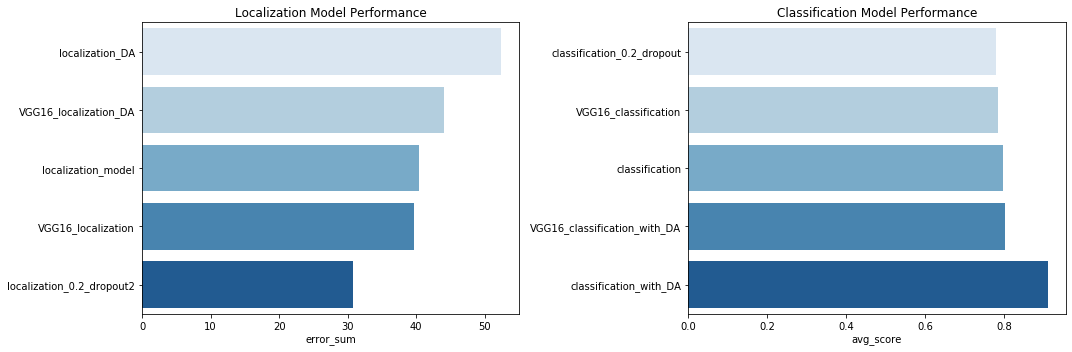

In [85]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
sns.barplot(x='error_sum',y='model', data=loc_df.sort_values(by='error_sum', ascending=False), palette='Blues')
ax1.set_ylabel('')
plt.title('Localization Model Performance')

ax2 = plt.subplot(1,2,2)
sns.barplot(x='avg_score', y='model', data=class_df.sort_values(by='avg_score'), palette='Blues')
plt.title('Classification Model Performance')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

Because we want the localization model with the smallest error terms, the localization_0.2_dropout2 model is the clear winner. In the classification models, we want the model with the greatest average score. Therefore, the classification_with_DA is again the best performing model.